In [1]:
%pip install -U torchtext==0.6
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import string
import numpy as np
import re
from pickle import load,dump
from unicodedata import normalize
from numpy import array
from numpy.random import rand
from numpy.random import shuffle
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [7]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [8]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [9]:
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [10]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [11]:
# load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')

Saved: english-german.pkl


In [12]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [13]:
raw_dataset = load_clean_sentences('english-german.pkl')
# reduce dataset size
n_sentences = 30000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:27000], dataset[27001:n_sentences]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')


Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [14]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [16]:
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [17]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [24]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1]) # germana
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0]) # engleza
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.load_weights('model.h5')

model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=35, batch_size=128, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 4937
English Max Length: 7
German Vocabulary Size: 8097
German Max Length: 11
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 256)           2072832   
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVecto  (None, 7, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 7, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 7, 4937)           1268809   
 ributed)                                                        
                   

C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2.46370 to 2.17737, saving model to model.h5
211/211 - 59s - loss: 2.1835 - val_loss: 2.1774 - 59s/epoch - 280ms/step
Epoch 3/35

Epoch 3: val_loss improved from 2.17737 to 1.98040, saving model to model.h5
211/211 - 68s - loss: 1.8318 - val_loss: 1.9804 - 68s/epoch - 322ms/step
Epoch 4/35

Epoch 4: val_loss improved from 1.98040 to 1.84249, saving model to model.h5
211/211 - 62s - loss: 1.5519 - val_loss: 1.8425 - 62s/epoch - 293ms/step
Epoch 5/35

Epoch 5: val_loss improved from 1.84249 to 1.74850, saving model to model.h5
211/211 - 62s - loss: 1.3221 - val_loss: 1.7485 - 62s/epoch - 296ms/step
Epoch 6/35

Epoch 6: val_loss improved from 1.74850 to 1.67585, saving model to model.h5
211/211 - 81s - loss: 1.1331 - val_loss: 1.6759 - 81s/epoch - 385ms/step
Epoch 7/35

Epoch 7: val_loss improved from 1.67585 to 1.63148, saving model to model.h5
211/211 - 81s - loss: 0.9778 - val_loss: 1.6315 - 81s/epoch - 382ms/step
Epoch 8/35

Epoch 8: val_loss improved 

KeyboardInterrupt: 

In [18]:
# Load model from model.h5

# load datasets
model = load_model('model.h5')




In [19]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [20]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [18]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [19]:
#print('train')
#evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

test
src=[wir konnen nicht verlieren], target=[we cant lose], predicted=[we cant lose]
src=[wir alle lieben tom], target=[we all love tom], predicted=[we all know tom]
src=[er liebt aufmerksamkeit], target=[he loves attention], predicted=[he loves himself]
src=[ich grille fisch], target=[i am grilling fish], predicted=[i am fish]
src=[ich wurde gerne gehen], target=[id like to go], predicted=[id like to go]
src=[du bist mein kind], target=[youre my child], predicted=[youre are of man]
src=[tom mangelt es an erfahrung], target=[tom lacks experience], predicted=[tom is to]
src=[das zimmer war warm], target=[the room was warm], predicted=[the room was warm]
src=[ich gehe um halb elf schlafen], target=[i go to bed at], predicted=[ill go at]
src=[ich habe meine lektion gelernt], target=[i learned my lesson], predicted=[i met my my]
BLEU-1: 0.592103
BLEU-2: 0.468498
BLEU-3: 0.409581
BLEU-4: 0.279858


In [1]:
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)

train


NameError: name 'evaluate_model' is not defined

In [21]:
# Functia de traducere
def translate(text):
    text_to_translate = [text]

    sequences = ger_tokenizer.texts_to_sequences(text_to_translate)
    sequences = pad_sequences(sequences, maxlen=ger_length, padding='post')

    translation = predict_sequence(model, eng_tokenizer, sequences)
    return translation


In [ ]:
source = "Ich bin h# eute schlechter Laune."
target = "I'm in a bad mood today."

output = translate(source)

# BLEU
bleu = corpus_bleu([target], [output], weights=(1.0, 0, 0, 0))
print(bleu)

In [19]:

source = "Es ist immer noch Montag."
target = "It's still Monday."

output = translate(source)
print(output)

# BLEU
bleu = corpus_bleu([target], [output], weights=(1.0, 0, 0, 0))
print(bleu)

its is over
0.45454545454545453


C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-pa

In [23]:

# Avem modelul antrenat de Alice.
# Luam o parte din datasetul pe care s-a antrenat modelul si il testam cu acesta => label IN probe
# Luam o alta parte din dataset pe care modelul lui Alice NU s-a antrenat si il testam si pe acesta => label OUT probe
# Construim un clasificator care, pe baza scorurilor generate pe fiecare label, acesta poate eticheta daca o propozitie
# este IN probe sau OUT probe
# Pentru testarea clasificatorului, se aleg alte bucati din dataset care sunt atat IN probe si OUT probe si se verifica
# acuratetea ghicelii. Daca per total avem rezultat de 50% sau mai putin => ESEC , altfel, atacul este un success


raw_dataset = load_clean_sentences('english-german.pkl')

dimension_to_split =  30000 #14000
max_dim = 100000
# reduce dataset size
n_sentences_limit = 5000 #5000
dataset = raw_dataset[:dimension_to_split, :]
# random shuffle
shuffle(dataset)

dataset_trained = dataset[:n_sentences_limit, :]

# make dataset_trained an array where first 3 columns are arrays and 4th column is a number
#dataset_trained = np.array(dataset_trained)
#dataset_trained = np.reshape(dataset_trained, (len(dataset_trained), 4))


column_pahar = []
new_dataset_trained = []
for sentence in dataset_trained:
    sentence = np.append(sentence, translate(sentence[1]))
    sentence = np.append(sentence, 1) # IN
    column_pahar = sentence[0]
    sentence[0] = sentence[1]
    sentence[1] = column_pahar
    bleu = corpus_bleu([sentence[1]], [sentence[2]], weights=(1.0, 0, 0, 0))
    sentence = np.append(sentence, bleu)
    new_dataset_trained.append(sentence)

dataset_2 = raw_dataset[dimension_to_split:max_dim, :]
# random shuffle
shuffle(dataset_2)
dataset_not_trained = dataset_2[:n_sentences_limit, :]

new_dataset_untrained = []
for sentence in dataset_not_trained:
    sentence = np.append(sentence, translate(sentence[1]))
    sentence = np.append(sentence, 0) # OUT
    column_pahar = sentence[0]
    sentence[0] = sentence[1]
    sentence[1] = column_pahar
    bleu = corpus_bleu([sentence[1]], [sentence[2]], weights=(1.0, 0, 0, 0))
    sentence = np.append(sentence, bleu)
    new_dataset_untrained.append(sentence)

# big_list = [dataset_trained, dataset_not_trained]
big_list = new_dataset_trained + new_dataset_untrained
shuffle(big_list)
# df = pd.DataFrame(dataset_trained, dataset_not_trained, )


# We luam 5000 de propozitii din A_train (folosite de Alice la training)
# Luam 5000 propozitii nefolosite in training si alcatuim un tabel de forma
# PROP_GERMANA  OUTPUT  TARGET  LABEL

# PROP_GERMANA = propozitia in germana
# OUTPUT = propozitia in engleza generata de Alice
# TARGET = propozitia in engleza corecta
# LABEL = IN sau OUT



NameError: name 'ger_tokenizer' is not defined

In [3]:
import pandas as pd 
# print (new_dataset_trained)
df = pd.DataFrame(big_list, columns=['INPUT', 'REF', 'OUTPUT', 'LABEL', 'BLEU'])

NameError: name 'big_list' is not defined

In [31]:
filename = 'dataset.csv'
df.to_csv(filename, sep=',', index=False, encoding='utf-8')

In [32]:
print(df)

                                    INPUT                              REF  \
0       wir fuhren mit dem bus zur schule         we went to school by bus   
1                    ist das nicht normal               is that not normal   
2                         tom ist genervt                     toms annoyed   
3     tom kam heute morgen wieder zu spat  tom was late again this morning   
4     ich habe meine brieftasche verloren            i have lost my wallet   
...                                   ...                              ...   
9995                       nimm noch eine                     have another   
9996                       du bist lehrer                you are a teacher   
9997               franzosisch ist schwer              french is difficult   
9998              das ist meine schwester                this is my sister   
9999       wir sind in ein auto gestiegen                we got into a car   

                  OUTPUT LABEL                 BLEU  
0       l

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [34]:
train_limit = int(8 / 10 * 2 * n_sentences_limit)

In [35]:
# df - dataset, split between training and testing
# NAIVE BAYES

df_train = df[:train_limit]
df_test = df[train_limit+1:]

X_train = df_train['BLEU']
y_train = df_train['LABEL']


# Train the classifier
classifier = MultinomialNB()
classifier.fit(X_train.values.reshape(-1, 1), y_train)
classifier.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = classifier.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.49024512256128067
Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       980
           1       0.00      0.00      0.00      1019

    accuracy                           0.49      1999
   macro avg       0.25      0.50      0.33      1999
weighted avg       0.24      0.49      0.32      1999



C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

Naive Bayes


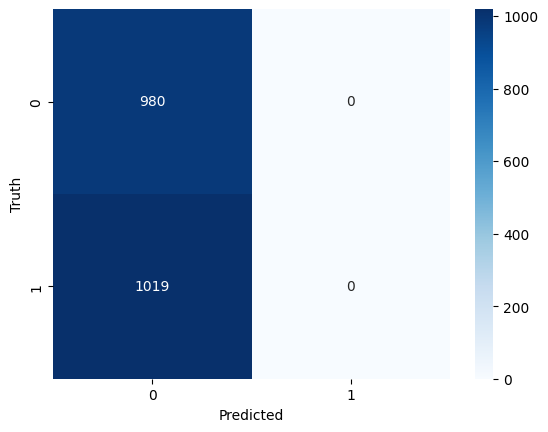

In [36]:
# Confussion matrix
# Naive Bayes
print("Naive Bayes")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [50]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X_train = df_train['BLEU']
y_train = df_train['LABEL']

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = clf.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)

print("Classification Report:")
print(report)


Accuracy: 0.5982991495747874
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.82      0.67       980
           1       0.69      0.39      0.50      1019

    accuracy                           0.60      1999
   macro avg       0.62      0.60      0.58      1999
weighted avg       0.63      0.60      0.58      1999



Random Forest


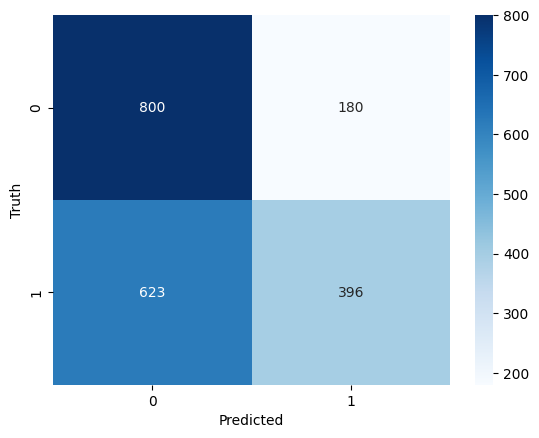

In [51]:
# Confussion matrix

# Random Forest
print("Random Forest")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [52]:
# NEAREST NEIGHBOUR
from sklearn.neighbors import KNeighborsClassifier

X_train = df_train['BLEU']
y_train = df_train['LABEL']

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data

y_pred = neigh.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)

print("Classification Report:")
print(report)

Accuracy: 0.5487743871935968
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       980
           1       0.57      0.48      0.52      1019

    accuracy                           0.55      1999
   macro avg       0.55      0.55      0.55      1999
weighted avg       0.55      0.55      0.55      1999



Nearest Neighbour


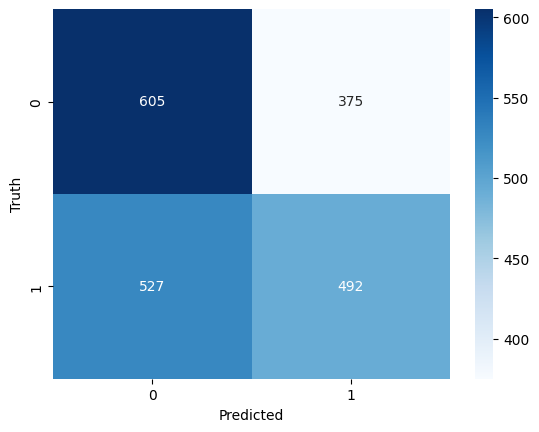

In [53]:
# Nearest Neighbour
print("Nearest Neighbour")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [54]:
# Perceptron

from sklearn.linear_model import Perceptron

X_train = df_train['BLEU']
y_train = df_train['LABEL']

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = clf.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)

print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)

print("Classification Report:")
print(report)


Accuracy: 0.5087543771885943
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.51      1.00      0.67      1019

    accuracy                           0.51      1999
   macro avg       0.25      0.50      0.34      1999
weighted avg       0.26      0.51      0.34      1999



Perceptron


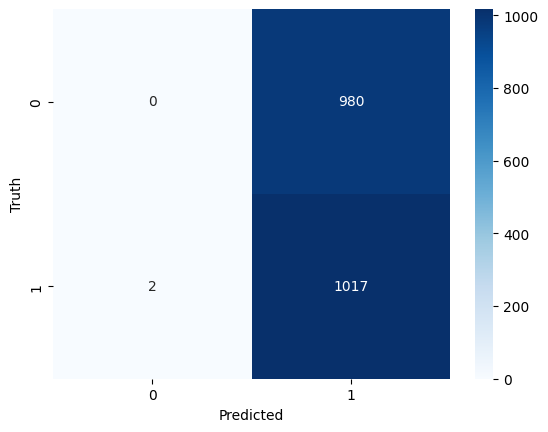

In [42]:
# Perceptron
print("Perceptron")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [55]:
# Multi-layer Perceptron (MLP)

from sklearn.neural_network import MLPClassifier

X_train = df_train['BLEU']
y_train = df_train['LABEL']

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = clf.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)

print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)

print("Classification Report:")
print(report)




Accuracy: 0.599799899949975
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       980
           1       0.64      0.49      0.56      1019

    accuracy                           0.60      1999
   macro avg       0.61      0.60      0.60      1999
weighted avg       0.61      0.60      0.60      1999



MLP


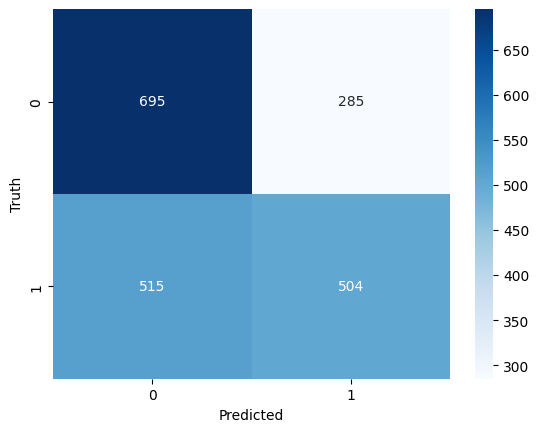

In [56]:
# MLP
print("MLP")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [49]:
# Decision Tree

from sklearn import tree

X_train = df_train['BLEU']
y_train = df_train['LABEL']

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = clf.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)
print("Classification Report:")
print(report)



Accuracy: 0.6048024012006002
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.76      0.65       980
           1       0.66      0.46      0.54      1019

    accuracy                           0.60      1999
   macro avg       0.62      0.61      0.60      1999
weighted avg       0.62      0.60      0.60      1999



Decision Tree


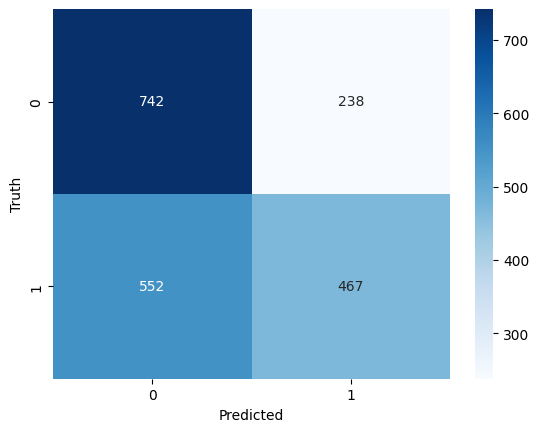

In [46]:
# Decision Tree

print("Decision Tree")

cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()